In [1]:
%matplotlib inline

# Basic library imports

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from Bio import SeqIO
from scipy import stats
import numpy as np

# Just some parameters that I like to use to make prettier plots

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Initial data processing

The rate file was constructed with the following code:

`iqtree -s ./IF2_423_modern_sequences.fasta -t ./IF2_423_tree_iqtree_output -m LG+F+R10 -wsr -nt 40`

Note that I set `-nt 40` because I ran this on our cluster and thus had access to many threads. On a home computer you'd want to set this to `-nt 1` or `-nt 2` most likely.

**Read in the (pre-computed) rate file and check it out a bit**

In [4]:
rate_df = pd.read_csv('../Data/Sequences_and_phylogeny/IF2_423_modern_sequences.fasta.rate', 
                      sep='\t', comment='#', index_col=0)
print(rate_df.shape)
rate_df.head()

(1995, 3)


,Rate,Cat,C_Rate
Site,,,
1,1.00000,10,2.17224
2,1.00000,10,2.17224
3,1.00000,10,2.17224
4,1.00000,10,2.17224
5,0.04541,2,0.07099


**Now read in the full E. coli sequence**

In [5]:
records = SeqIO.parse('../Data/Sequences_and_phylogeny/IF2_423_modern_sequences.fasta', 'fasta')
for record in records:
    if 'E.coli' in record.id:
        print(record.id)
        ecoli_seq = str(record.seq)

Gammaproteobacteria_E.coli_IF2


**Locate the index within the E. coli sequence where our structures roughly begin**

In [6]:
ecoli_seq.replace('-', '').find('EPRAPVVTIMGHVDHGKTSLL')

387

**Assign a new column for the E. coli sequence in the rate dataframe (this will include regions that are gapped in E. coli)**

In [7]:
rate_df['Ecoli_seq'] = list(ecoli_seq)
rate_df.head()

,Rate,Cat,C_Rate,Ecoli_seq
Site,,,,
1,1.00000,10,2.17224,-
2,1.00000,10,2.17224,-
3,1.00000,10,2.17224,-
4,1.00000,10,2.17224,-
5,0.04541,2,0.07099,-


**The rates *should* be constructed such that they are fully relative. The alignment wide average should be 1 which indicates that a value of 2 means that this site evolves twice as fast as the average for the alignment whereas a value of 0.5 indicates that this site evolves half as quickly as the alignment average**

In [8]:
print(rate_df['Rate'].mean(), rate_df['Rate'].std())

1.0001905012531314 0.5945748449444963


**But there are a lot of sites in the alignment where *E. coli* is gapped, so lets only consider sites with valid *E. coli* alignments. Note that the alignment wide average of this subset is now not 1 and it's unclear whether we should re-scale these values or not. Probably not a big deal either way.**

In [9]:
ecoli_df = rate_df[rate_df['Ecoli_seq']!='-'] 
print(ecoli_df['Rate'].mean(), ecoli_df['Rate'].std())

0.7173796966292136 0.6095004633697498


To re-scale, we would just say:

```
ecoli_df['Rate'] = ecoli_df['Rate'] / ecoli_df['Rate'].mean()
```

But I'm not sure what the best thing to do here is.

# Initial data exploration

**Histograms of raw data and log-scaled**

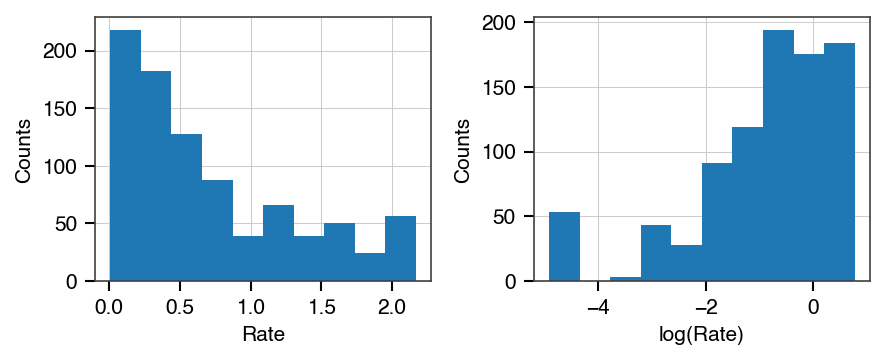

In [10]:
fig, ax_arr = plt.subplots(ncols=2, figsize=(6,2.5))
ax_arr[0].hist(ecoli_df['Rate'])
ax_arr[0].set_xlabel('Rate')
ax_arr[0].set_ylabel('Counts')
ax_arr[1].hist(np.log(ecoli_df['Rate']))
ax_arr[1].set_xlabel('log(Rate)')
ax_arr[1].set_ylabel('Counts')
plt.tight_layout()

**Plots of the rate (and log-scaled rate) along the length of the E. coli sequence**

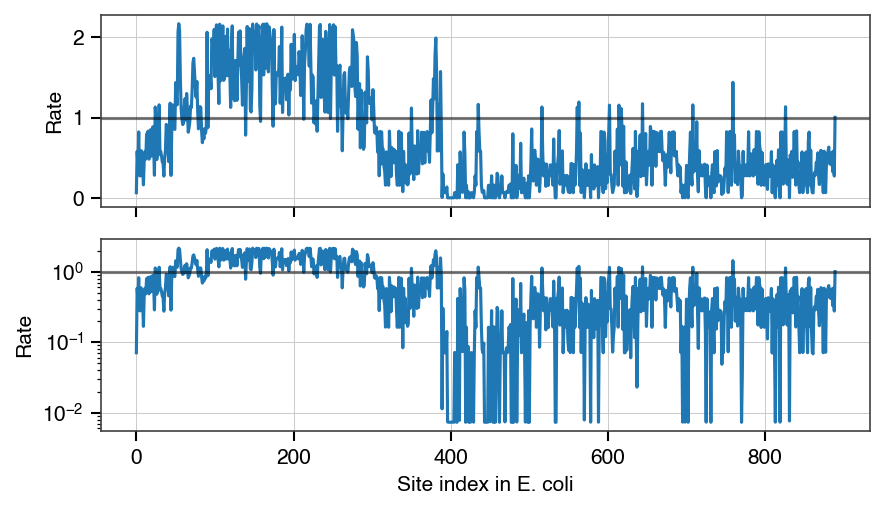

In [11]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(6,3.5))
ax_arr[0].plot(range(ecoli_df.shape[0]), ecoli_df['Rate'])
ax_arr[0].set_ylabel('Rate')
ax_arr[0].axhline(1., c='k', alpha=0.5)
ax_arr[0].set_xticklabels('')
ax_arr[1].semilogy(range(ecoli_df.shape[0]), ecoli_df['Rate'])
ax_arr[1].set_xlabel('Site index in E. coli')
ax_arr[1].set_ylabel('Rate')
ax_arr[1].axhline(1., c='k', alpha=0.5)
plt.tight_layout()
#plt.savefig('../Results/Figures/my_cool_figurename.pdf')

# Protein domain annotations

This will be useful for constructing statistical comparisons between domains. I used information found on these sites to roughly annotate these domains, but I wish there was a more structure-based way that I liked better. 

1. https://www.uniprot.org/uniprot/P0A705 

2. https://www.ebi.ac.uk/interpro/protein/UniProt/P0A705/

In [12]:
#Insert your favorite definition of where the domains occur here
# domains = [(389, 557),
#           (563, 644),
#           (667, 796),
#           (791, 887)]
#PDOM THREADER 
# domains = [(397, 559),
#           (560,649),
#           (684, 753),
#           (798, 888)]
#N1, N2, G1, G2, G3, C1, C2
domains = [(1, 157),
           (158, 294),
           (295, 388), 
           (389, 561),
           (562,658),
           (659, 793),
           (794, 890)]

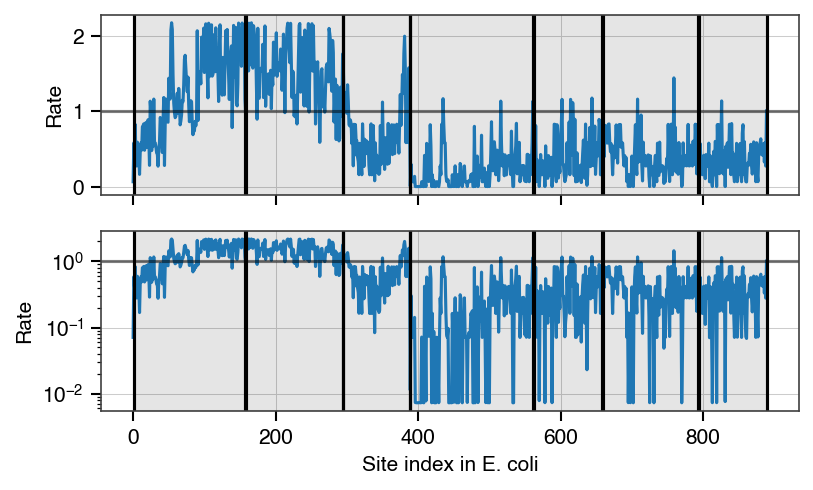

In [13]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(6,3.5))
ax_arr[0].plot(range(ecoli_df.shape[0]), ecoli_df['Rate'])
ax_arr[0].set_ylabel('Rate')
ax_arr[0].axhline(1., c='k', alpha=0.5)
ax_arr[0].set_xticklabels('')
ax_arr[1].semilogy(range(ecoli_df.shape[0]), ecoli_df['Rate'])
ax_arr[1].set_xlabel('Site index in E. coli')
ax_arr[1].set_ylabel('Rate')
ax_arr[1].axhline(1., c='k', alpha=0.5)
for domain in domains:
    ax_arr[0].axvspan(domain[0], domain[1], alpha=0.1, color='k')
    ax_arr[0].axvline(domain[0], c='k')
    ax_arr[0].axvline(domain[1], c='k')
    ax_arr[1].axvspan(domain[0], domain[1], alpha=0.1, color='k')
    ax_arr[1].axvline(domain[0], c='k')
    ax_arr[1].axvline(domain[1], c='k')

**Statistically assess variation between the domains**

(Domain boundaries), Mean substitution rate

(1, 157) 1.2371453846153848
(158, 294) 1.5299289705882353
(295, 388) 0.687213440860215
(389, 561) 0.22255529069767443
(562, 658) 0.3978228125
(659, 793) 0.4072298507462686
(794, 890) 0.3745003125

Stats: KruskalResult(statistic=541.1629616634824, pvalue=1.1343110586820715e-113)


/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Relative substitution rate')

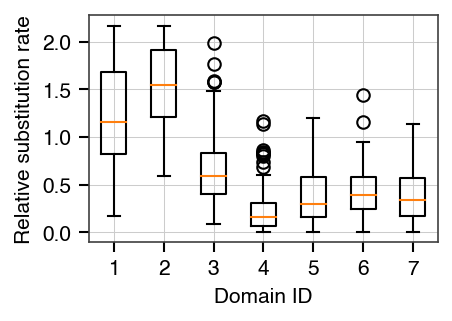

In [14]:
to_compare = []
print('(Domain boundaries), Mean substitution rate')
print()
for domain in domains:
    to_compare.append(list(ecoli_df['Rate'][domain[0]:domain[1]]))
    print(domain, np.mean(list(ecoli_df['Rate'][domain[0]:domain[1]])))
    
print()
print('Stats:', stats.kruskal(*to_compare))

fig, ax = plt.subplots(figsize=(3,2))
ax.boxplot(to_compare)
ax.set_xlabel('Domain ID')
ax.set_ylabel('Relative substitution rate')

**Comparing sites that are in and outside of the listed domains (Note: this only works/makes sense if your domain definitions exclude linker regions! Otherwise everything is within a domain of some sort except perhaps a few bases at the edges of the sequence that avoided classification)**


N in domain, out of domain, and combined: 883 7 890

Domain rates: 0.7157046432616081

Not domain rates: 0.9286757142857144

Stats: RanksumsResult(statistic=-1.2694653474569166, pvalue=0.2042751421538871)


/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Relative substitution rate')

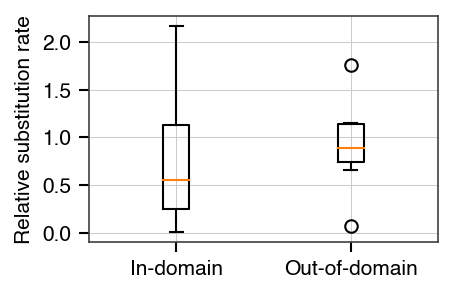

In [16]:
domain_rates = []
not_domain_rates = []
for i in range(ecoli_df.shape[0]):
    in_domain = False
    for domain in domains:
        if i >= domain[0] and i < domain[1]:
            in_domain = True
    if in_domain == True:
        domain_rates.append(ecoli_df.iloc[i]['Rate'])
    else:
        not_domain_rates.append(ecoli_df.iloc[i]['Rate'])
print('N in domain, out of domain, and combined:', len(domain_rates),
                                                      len(not_domain_rates),
                                                      len(domain_rates)+len(not_domain_rates))
print()
print('Domain rates:', np.mean(domain_rates))
print()
print('Not domain rates:', np.mean(not_domain_rates))
print()
print('Stats:', stats.ranksums(domain_rates, not_domain_rates))

fig, ax = plt.subplots(figsize=(3,2))
ax.boxplot([domain_rates, not_domain_rates])
ax.set_xticklabels(['In-domain', 'Out-of-domain'])
ax.set_ylabel('Relative substitution rate')

# Final thoughts

Relative substitution rate is simply a way to quantitatively determine the degree of conservation at a given site. Rather than to look at the entropy of sites (which used to be common), rates actually consider the topology of the tree and are thus much preferred.

However, rates are not the *best* way to assess selection. Most folks would say you want to get coding sequence alignments (that correspond to the amino acid alignments) and then you can do site-specific dN/dS measurements which quantify the non-synonymous to synonymous substitution rates to identify specific sites that are under the strongest level of evolutionary selection. A few programs do this including `PAML` (the `codeml` package) and `HyPhy`. Neither are particularly easy to work with. And again, whether it's worth doing depends on what one would hypothesize to find. Simply quantifying selection for its own sake is probably not an end-goal and thus not worth it unless we had specific hypotheses to test. 